# Import Package

In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import legend
plt.rcParams["figure.figsize"] = (24,8)

# Read Data

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
PATH = '/content/drive/MyDrive/Citadel Datathon/Data/'

df_bid = pd.read_csv(PATH+'Ziao/bidding.csv')
df_bid.date = pd.to_datetime(df_bid.date)

In [ ]:
df_raw = pd.read_csv(PATH+'data_raw.csv')

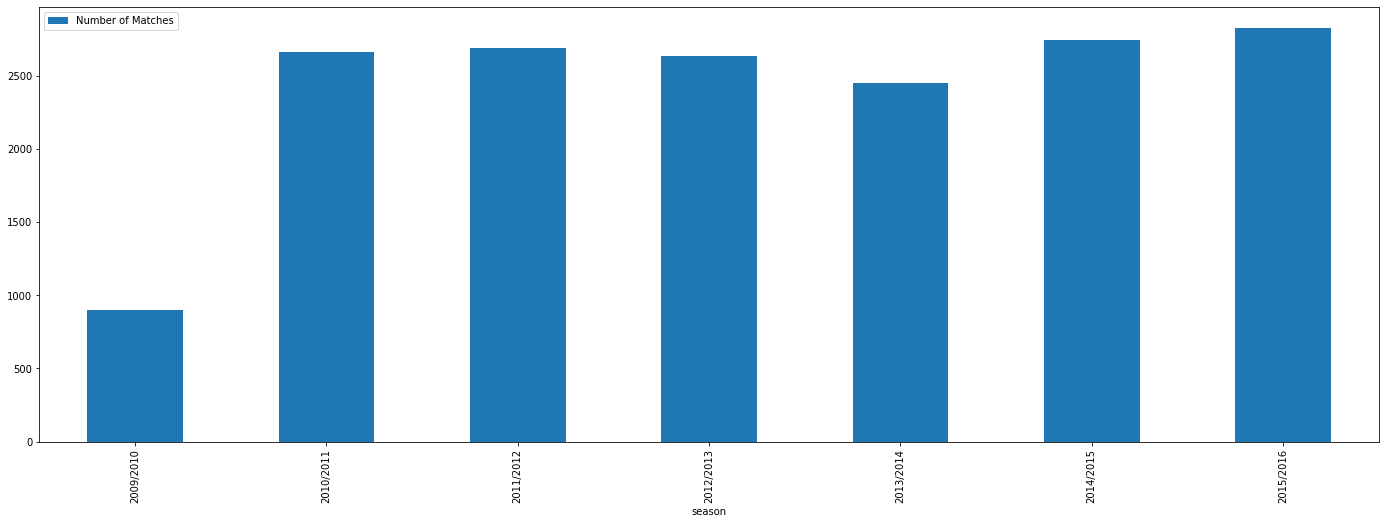

In [ ]:
df_raw.groupby(['season'])[['match_id']].count().plot.bar()
plt.legend(['Number of Matches'])

In [19]:
with open(PATH+'Jay/classification_table_test.pkl','rb') as file:
  df_cla_test = pickle.load(file)

with open(PATH+'Jay/regression_table_test.pkl','rb') as file:
  df_reg_test = pickle.load(file)

# Back Test

## Back Test Functions

In [8]:
def back_test_reg(preds, bid, company='B365',reinvest=0.1, draw_threshold=0.33, invest_threshold=0.1):
  odds_col = [company+i for i in "HDA"]
  preds = pd.merge(preds, bid[['match_id','match_result']+ odds_col], on='match_id')

  def get_ret(row):
    match_result = row['match_result']
    pred = row['pred']
    if pred > draw_threshold+invest_threshold:
      if match_result == 'win':
        return row[company+'H'] - 1
      else:
        return -1
    elif pred < -draw_threshold-invest_threshold:
      if match_result == 'lose':
        return row[company+'A'] - 1
      else:
        return -1
    elif pred < draw_threshold - invest_threshold and pred > -draw_threshold + invest_threshold:
      if match_result == 'draw':
        return row[company+'D'] - 1
      else:
        return -1
    else:
      return 0

  preds['ret'] = preds.apply(get_ret, axis=1)
  preds = preds[preds.ret != 0]
  rets = preds.groupby(['date'], as_index=False).agg({'match_id': 'count','ret': 'sum'})
  rets['ret'] = rets['ret'] / rets['match_id']

  # Only half to bet
  rets['ret'] = rets['ret']*reinvest + 1
  rets['cum_ret'] = rets['ret'].cumprod()
  rets['ret'] = rets['ret'] - 1
  return preds, rets



In [40]:
import random

pred_result = ['win','lose','draw']
def random_bet(preds, bid, company='B365',reinvest=0.1):
  odds_col = [company+i for i in "HDA"]
  preds = pd.merge(preds, bid[['match_id','match_result']+ odds_col], on='match_id')

  def get_ret(row):
    match_result = row['match_result']
    pred = random.choice(pred_result)
    if pred == match_result:
      if pred == 'win':
        return row[company+'H']-1
      elif pred == 'draw':
        return row[company+'D']-1
      else:
        return row[company+'A']-1
    else:
      return -1

  preds['ret'] = preds.apply(get_ret, axis=1)
  preds = preds[preds.ret != 0]
  rets = preds.groupby(['date'], as_index=False).agg({'match_id': 'count','ret': 'sum'})
  rets['ret'] = rets['ret'] / rets['match_id']

  # Only half to bet
  rets['ret'] = rets['ret']*reinvest + 1
  rets['cum_ret'] = rets['ret'].cumprod()
  rets['ret'] = rets['ret'] - 1
  return rets

In [9]:
def back_test_cla(preds, bid, company='B365',reinvest=0.1, draw_threshold=0.33, invest_threshold=0.4):
  odds_col = [company+i for i in "HDA"]
  preds = pd.merge(preds, bid[['match_id','match_result']+ odds_col], on='match_id')

  def get_ret(row):
    match_result = row['match_result']
    label = ('win', 'lose', 'draw')
    odds_label = ('H', 'A', 'D')
    probs = (row['2'], row['1'], row['0'])
    if max(probs) > invest_threshold:
      prob = max(probs)
      if row['match_result'] == label[probs.index(prob)]:
        return row[company+odds_label[probs.index(prob)]]-1
      else:
        return -1
    else:
      return 0


  preds['ret'] = preds.apply(get_ret, axis=1)
  rets = preds.groupby(['date'], as_index=False).agg({'match_id': 'count','ret': 'sum'})
  rets['ret'] = rets['ret'] / rets['match_id']

  # Only half to bet
  rets['ret'] = rets['ret']*reinvest + 1
  rets['cum_ret'] = rets['ret'].cumprod()
  rets['ret'] = rets['ret'] - 1
  return rets[['date','ret','cum_ret']]


In [57]:
def get_SR(ret):
  ret['year'] = ret.date.apply(lambda x: str(x.year))
  ret['ret'] = ret['ret']+1 
  ret = ret.groupby(['year'], as_index=False)[['ret']].prod()
  ret['ret'] = ret['ret'] - 1
  return (ret['ret'].mean() - 0.021) / (ret['ret'] - 0.021).std()

## Benchmark (Random)

In [53]:
df_cla_test[0][1]

,match_id,date,0,1,2,pred
2000,1724042,2014-10-04,0.154198,0.795500,0.050302,lose
2001,1724044,2014-10-04,0.320610,0.273267,0.406122,win
2002,1724045,2014-10-04,0.128692,0.403648,0.467660,win
2003,1724046,2014-10-04,0.204513,0.198128,0.597359,win
2004,1724048,2014-10-04,0.175407,0.395792,0.428801,win
...,...,...,...,...,...,...
6995,2060621,2016-05-08,0.270550,0.591897,0.137553,lose
6996,2060622,2016-05-08,0.202117,0.142820,0.655063,win
6997,2060623,2016-05-08,0.252951,0.533003,0.214046,lose
6998,2060624,2016-05-08,0.233293,0.570485,0.196222,lose


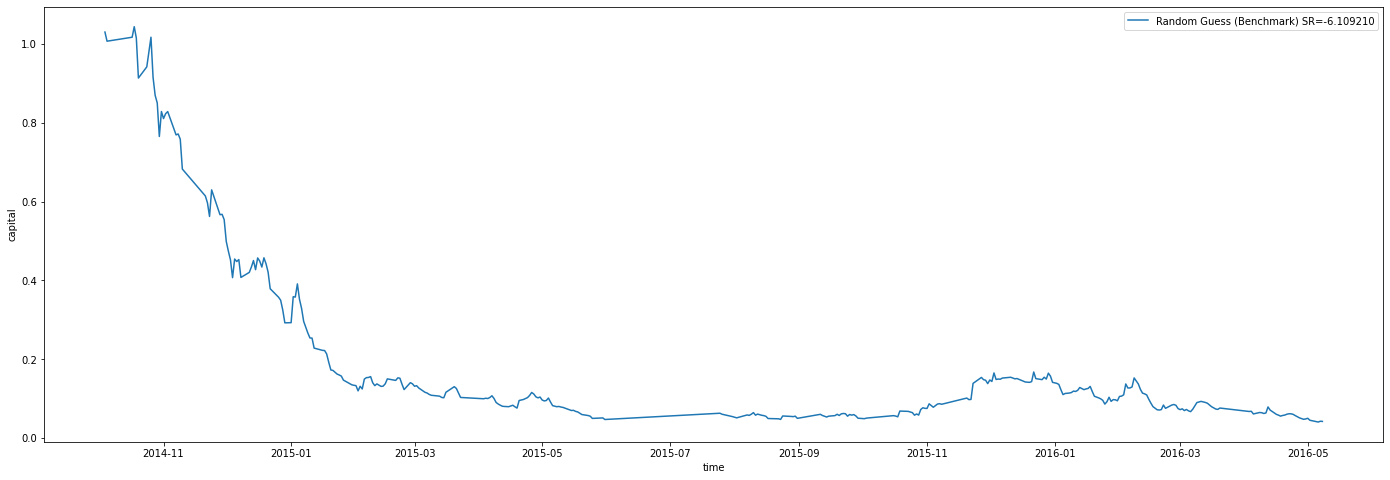

In [64]:
random.seed(4321)
random_guess = random_bet(df_cla_test[0][1], df_bid, reinvest=0.1)
plt.plot(random_guess.date, random_guess.cum_ret, label='Random Guess (Benchmark) SR=%f'%get_SR(random_guess))
plt.legend()
plt.ylabel('capital')
plt.xlabel('time')
plt.show()

## Classification

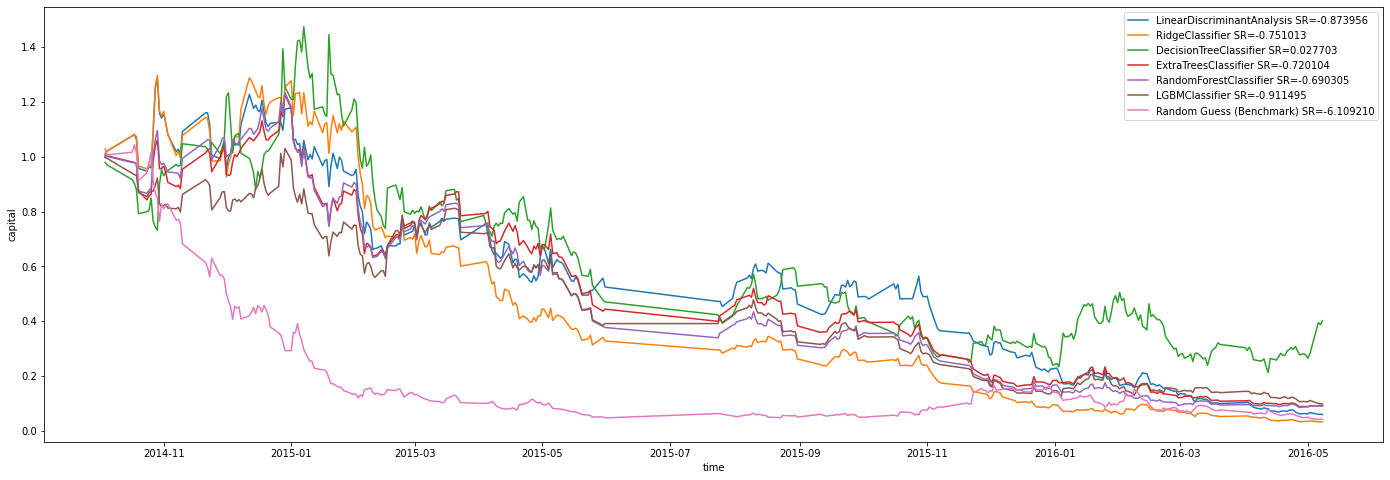

In [65]:
for m in df_cla_test:
  name = m[0]
  if 'XGB' not in name:
    res = m[1]
    rets = back_test_cla(res, df_bid, reinvest=0.1, invest_threshold=0.4)
    plt.plot(rets.date, rets.cum_ret, label=name+' SR=%f'%get_SR(rets))
random.seed(4321)
random_guess = random_bet(df_cla_test[0][1], df_bid, reinvest=0.1)
plt.plot(random_guess.date, random_guess.cum_ret, label='Random Guess (Benchmark) SR=%f'%get_SR(random_guess))
plt.legend()
plt.ylabel('capital')
plt.xlabel('time')
plt.show()

## Regression

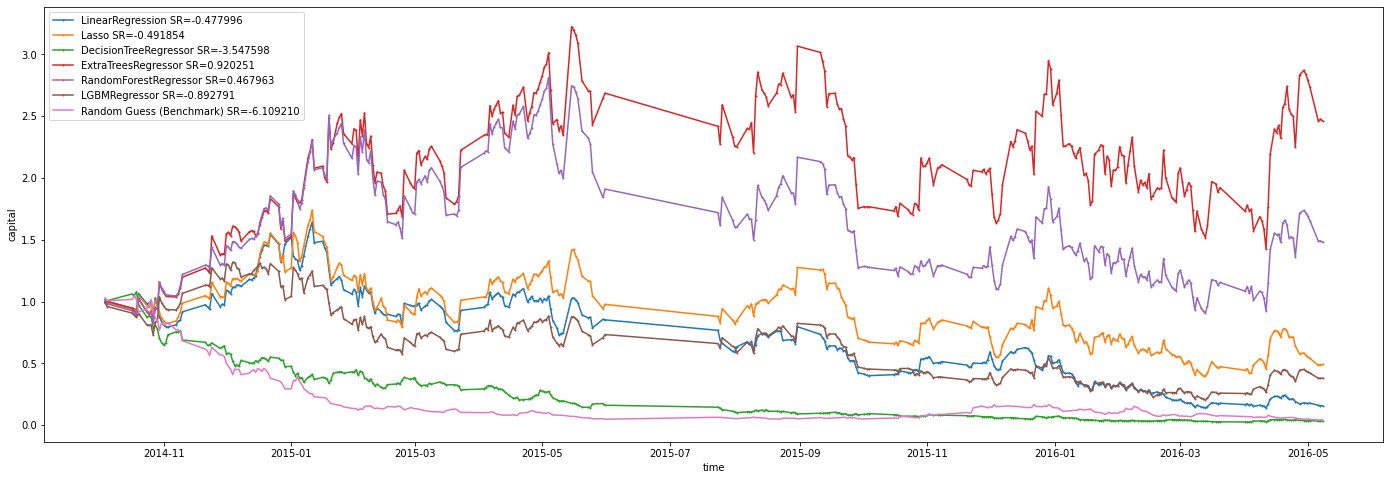

In [66]:
for m in df_reg_test:
  name = m[0]
  if name not in ['HuberRegressor', 'BayesianRidge', 'OrthogonalMatchingPursuit'] and 'XGB' not in name:
    res = m[1]
    preds, rets = back_test_reg(res, df_bid,reinvest=0.1, invest_threshold=0)
    plt.plot(rets.date, rets.cum_ret, "-o", markersize=1, label=name+' SR=%f'%get_SR(rets))
random.seed(4321)
random_guess = random_bet(df_cla_test[0][1], df_bid, reinvest=0.1)
plt.plot(random_guess.date, random_guess.cum_ret, label='Random Guess (Benchmark) SR=%f'%get_SR(random_guess))
plt.legend()
plt.ylabel('capital')
plt.xlabel('time')
plt.show()